In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import optuna
from optuna.trial import TrialState
import pickle

/home/guilhermemaciel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

#### Declarando as funções de avaliação do modelo

In [4]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [5]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [7]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [8]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [9]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [10]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [11]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [12]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo xgboost base

Utilizaremos configurações similares a configuração base do random forest, para comparação

In [13]:
params = {
    'max_depth': 10,
    'eta': 0.1,  #Learning Rate
    'objective': 'binary:logistic', # Escolha para classificação binária
    'eval_metric': 'auc',            # Avaliando via AUC
    'seed' : 51
}

##### Criando instância DMatrix

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [15]:
model = xgb.train(params, dtrain, 50, evals=[(dval, 'validation')], early_stopping_rounds=5)


[0]	validation-auc:0.98732
[1]	validation-auc:0.98779
[2]	validation-auc:0.98877
[3]	validation-auc:0.98898
[4]	validation-auc:0.98917
[5]	validation-auc:0.98932
[6]	validation-auc:0.98960
[7]	validation-auc:0.98976
[8]	validation-auc:0.99003
[9]	validation-auc:0.99028
[10]	validation-auc:0.99051
[11]	validation-auc:0.99060
[12]	validation-auc:0.99083
[13]	validation-auc:0.99097
[14]	validation-auc:0.99113
[15]	validation-auc:0.99124
[16]	validation-auc:0.99158
[17]	validation-auc:0.99179
[18]	validation-auc:0.99194
[19]	validation-auc:0.99204
[20]	validation-auc:0.99219
[21]	validation-auc:0.99229
[22]	validation-auc:0.99244
[23]	validation-auc:0.99254
[24]	validation-auc:0.99262
[25]	validation-auc:0.99268
[26]	validation-auc:0.99275
[27]	validation-auc:0.99281
[28]	validation-auc:0.99289
[29]	validation-auc:0.99293
[30]	validation-auc:0.99299
[31]	validation-auc:0.99303
[32]	validation-auc:0.99306
[33]	validation-auc:0.99308
[34]	validation-auc:0.99313
[35]	validation-auc:0.99314
[3

#### Avaliando o Modelo


In [16]:
xgb_pred_scores = model.predict(dtest)

# Calculando a probabilidade da classe negativa
neg_class_probs = 1 - xgb_pred_scores

# Concatenando as duas arrays para formar um array 2D
xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

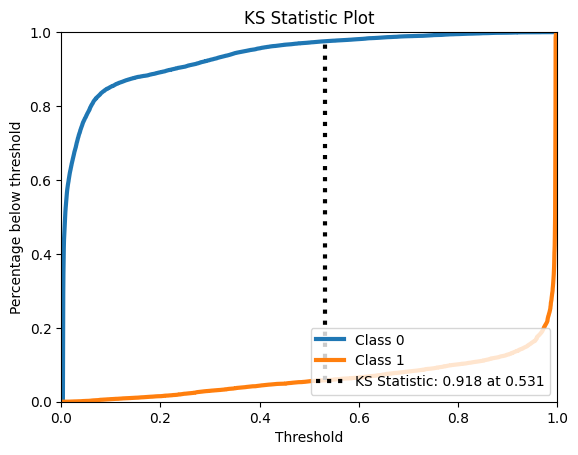



xgboost - Test

Accuracy:         0.9599
Recall:           0.9445
Precision:        0.9625
F1:               0.9534
AUROC:            0.9942
AUPR:             0.9932


In [17]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
print('\n\nxgboost - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

In [19]:
def objective(trial):

    global dtrain
    global dval
    global dtest
    global y_test

    params = {
        'max_depth': trial.suggest_int('max_depth', 3,  50),
        'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate
        'objective': 'binary:logistic', # Escolha para classificação binária
        'eval_metric': 'auc',        # Avaliando via AUC
        'lambda' : trial.suggest_int('lambda', 1,  5), # L2 regularization term on weights
        'alpha' : trial.suggest_int('alpha', 1,  5),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'seed' : 51,
    }



    trial.set_user_attr("max_depth", params["max_depth"])
    trial.set_user_attr("eta", params["eta"])
    trial.set_user_attr("lambda", params["lambda"])
    trial.set_user_attr("alpha", params["alpha"])
    trial.set_user_attr("grow_policy", params["grow_policy"])

    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = xgb.train(params, dtrain, 100, evals=[(dval, 'validation')], early_stopping_rounds=5)

    
    xgb_pred_scores = model.predict(dtest)

    neg_class_probs = 1 - xgb_pred_scores

    xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
    xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, xgb_pred_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
    print(f'\n\nXgboost\neta: {params["eta"]}\nmax_depth:{params["max_depth"]}\nlambda:{params["lambda"]}\nalpha:{params["alpha"]}\ngrow_policy:{params["grow_policy"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)

    pickle.dump(model, open(f'../models/xgb_{trial.number}.pkl', 'wb'))
    
    return auroc, ks_statistic


[I 2024-07-30 14:04:29,791] A new study created in memory with name: no-name-ead09e02-97f7-494b-bd67-01eaf4cd5dbd


[0]	validation-auc:0.96697
[1]	validation-auc:0.96832
[2]	validation-auc:0.97337
[3]	validation-auc:0.97537
[4]	validation-auc:0.97643
[5]	validation-auc:0.97751
[6]	validation-auc:0.98065
[7]	validation-auc:0.98176
[8]	validation-auc:0.98321


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[9]	validation-auc:0.98412
[10]	validation-auc:0.98492
[11]	validation-auc:0.98571
[12]	validation-auc:0.98607
[13]	validation-auc:0.98638
[14]	validation-auc:0.98666
[15]	validation-auc:0.98722
[16]	validation-auc:0.98743
[17]	validation-auc:0.98762
[18]	validation-auc:0.98791
[19]	validation-auc:0.98812
[20]	validation-auc:0.98824
[21]	validation-auc:0.98851
[22]	validation-auc:0.98866
[23]	validation-auc:0.98888
[24]	validation-auc:0.98912
[25]	validation-auc:0.98969
[26]	validation-auc:0.98980
[27]	validation-auc:0.98993
[28]	validation-auc:0.99010
[29]	validation-auc:0.99028
[30]	validation-auc:0.99037
[31]	validation-auc:0.99042
[32]	validation-auc:0.99045
[33]	validation-auc:0.99054
[34]	validation-auc:0.99071
[35]	validation-auc:0.99080
[36]	validation-auc:0.99104
[37]	validation-auc:0.99111
[38]	validation-auc:0.99115
[39]	validation-auc:0.99123
[40]	validation-auc:0.99134
[41]	validation-auc:0.99139
[42]	validation-auc:0.99148
[43]	validation-auc:0.99166
[44]	validation-auc:0

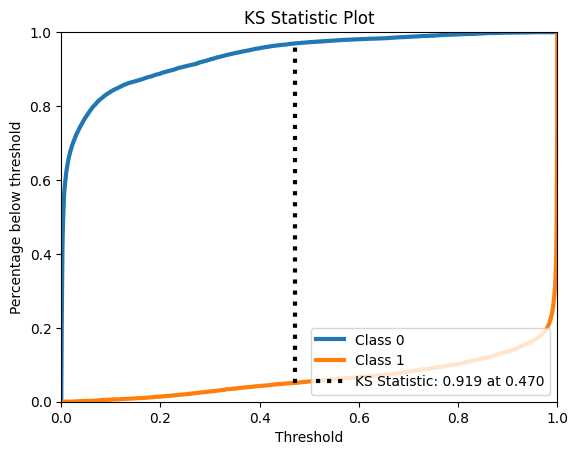

[I 2024-07-30 14:04:31,460] Trial 0 finished with values: [0.9942439985207154, 0.9186944920127399] and parameters: {'max_depth': 5, 'eta': 0.2, 'lambda': 2, 'alpha': 5, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.2
max_depth:5
lambda:2
alpha:5
grow_policy:lossguide

Accuracy:         0.9609
Recall:           0.9454
Precision:        0.9638
F1:               0.9545
AUROC:            0.9942
AUPR:             0.9932
[0]	validation-auc:0.98373
[1]	validation-auc:0.98546
[2]	validation-auc:0.98906
[3]	validation-auc:0.98950
[4]	validation-auc:0.99002
[5]	validation-auc:0.99027
[6]	validation-auc:0.99062
[7]	validation-auc:0.99103


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[8]	validation-auc:0.99118
[9]	validation-auc:0.99141
[10]	validation-auc:0.99170
[11]	validation-auc:0.99190
[12]	validation-auc:0.99201
[13]	validation-auc:0.99240
[14]	validation-auc:0.99255
[15]	validation-auc:0.99274
[16]	validation-auc:0.99283
[17]	validation-auc:0.99301
[18]	validation-auc:0.99307
[19]	validation-auc:0.99317
[20]	validation-auc:0.99323
[21]	validation-auc:0.99331
[22]	validation-auc:0.99339
[23]	validation-auc:0.99347
[24]	validation-auc:0.99355
[25]	validation-auc:0.99362
[26]	validation-auc:0.99366
[27]	validation-auc:0.99371
[28]	validation-auc:0.99374
[29]	validation-auc:0.99377
[30]	validation-auc:0.99381
[31]	validation-auc:0.99385
[32]	validation-auc:0.99386
[33]	validation-auc:0.99387
[34]	validation-auc:0.99391
[35]	validation-auc:0.99394
[36]	validation-auc:0.99397
[37]	validation-auc:0.99401
[38]	validation-auc:0.99405
[39]	validation-auc:0.99406
[40]	validation-auc:0.99408
[41]	validation-auc:0.99409
[42]	validation-auc:0.99411
[43]	validation-auc:0.

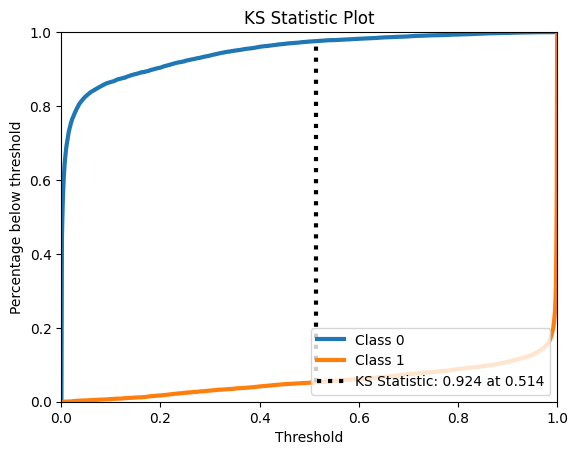

[I 2024-07-30 14:04:33,588] Trial 1 finished with values: [0.9949632159382326, 0.9236914608813933] and parameters: {'max_depth': 24, 'eta': 0.15000000000000002, 'lambda': 4, 'alpha': 4, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.15000000000000002
max_depth:24
lambda:4
alpha:4
grow_policy:depthwise

Accuracy:         0.9632
Recall:           0.9486
Precision:        0.9660
F1:               0.9572
AUROC:            0.9950
AUPR:             0.9941
[0]	validation-auc:0.98340
[1]	validation-auc:0.98476
[2]	validation-auc:0.98814
[3]	validation-auc:0.98910
[4]	validation-auc:0.98936
[5]	validation-auc:0.98970
[6]	validation-auc:0.99031
[7]	validation-auc:0.99055


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[8]	validation-auc:0.99077
[9]	validation-auc:0.99112
[10]	validation-auc:0.99151
[11]	validation-auc:0.99173
[12]	validation-auc:0.99215
[13]	validation-auc:0.99239
[14]	validation-auc:0.99254
[15]	validation-auc:0.99264
[16]	validation-auc:0.99270
[17]	validation-auc:0.99284
[18]	validation-auc:0.99295
[19]	validation-auc:0.99304
[20]	validation-auc:0.99315
[21]	validation-auc:0.99324
[22]	validation-auc:0.99331
[23]	validation-auc:0.99337
[24]	validation-auc:0.99346
[25]	validation-auc:0.99356
[26]	validation-auc:0.99363
[27]	validation-auc:0.99366
[28]	validation-auc:0.99369
[29]	validation-auc:0.99373
[30]	validation-auc:0.99375
[31]	validation-auc:0.99381
[32]	validation-auc:0.99388
[33]	validation-auc:0.99392
[34]	validation-auc:0.99397
[35]	validation-auc:0.99401
[36]	validation-auc:0.99405
[37]	validation-auc:0.99408
[38]	validation-auc:0.99410
[39]	validation-auc:0.99412
[40]	validation-auc:0.99414
[41]	validation-auc:0.99416
[42]	validation-auc:0.99418
[43]	validation-auc:0.

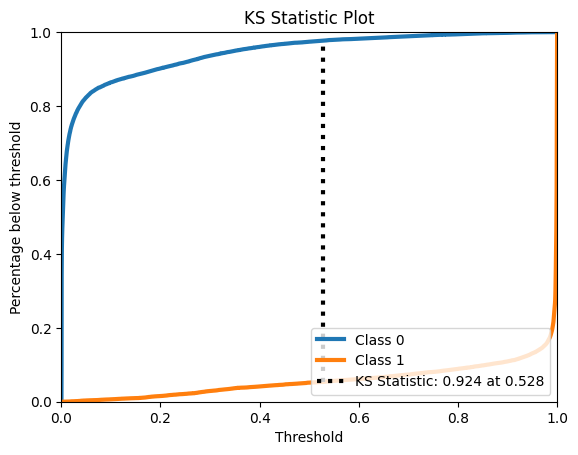

[I 2024-07-30 14:04:35,585] Trial 2 finished with values: [0.9950487371509773, 0.923679277756566] and parameters: {'max_depth': 41, 'eta': 0.15000000000000002, 'lambda': 5, 'alpha': 5, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.15000000000000002
max_depth:41
lambda:5
alpha:5
grow_policy:depthwise

Accuracy:         0.9629
Recall:           0.9483
Precision:        0.9656
F1:               0.9569
AUROC:            0.9950
AUPR:             0.9942
[0]	validation-auc:0.98374
[1]	validation-auc:0.98884
[2]	validation-auc:0.98965
[3]	validation-auc:0.99027
[4]	validation-auc:0.99103
[5]	validation-auc:0.99129


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[6]	validation-auc:0.99164
[7]	validation-auc:0.99217
[8]	validation-auc:0.99249
[9]	validation-auc:0.99277
[10]	validation-auc:0.99294
[11]	validation-auc:0.99306
[12]	validation-auc:0.99320
[13]	validation-auc:0.99329
[14]	validation-auc:0.99342
[15]	validation-auc:0.99353
[16]	validation-auc:0.99358
[17]	validation-auc:0.99364
[18]	validation-auc:0.99368
[19]	validation-auc:0.99376
[20]	validation-auc:0.99383
[21]	validation-auc:0.99393
[22]	validation-auc:0.99398
[23]	validation-auc:0.99404
[24]	validation-auc:0.99407
[25]	validation-auc:0.99407
[26]	validation-auc:0.99410
[27]	validation-auc:0.99413
[28]	validation-auc:0.99415
[29]	validation-auc:0.99419
[30]	validation-auc:0.99419
[31]	validation-auc:0.99421
[32]	validation-auc:0.99420
[33]	validation-auc:0.99421
[34]	validation-auc:0.99422
[35]	validation-auc:0.99423
[36]	validation-auc:0.99425
[37]	validation-auc:0.99424
[38]	validation-auc:0.99423
[39]	validation-auc:0.99422
[40]	validation-auc:0.99423


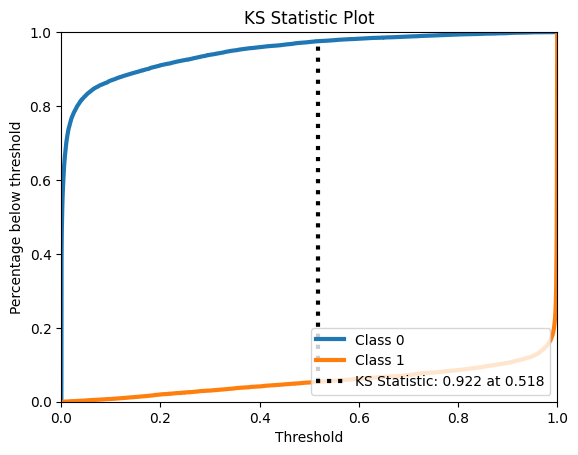

[I 2024-07-30 14:04:37,401] Trial 3 finished with values: [0.9949449180891574, 0.9219582415212699] and parameters: {'max_depth': 16, 'eta': 0.25, 'lambda': 5, 'alpha': 3, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.25
max_depth:16
lambda:5
alpha:3
grow_policy:lossguide

Accuracy:         0.9622
Recall:           0.9479
Precision:        0.9645
F1:               0.9561
AUROC:            0.9949
AUPR:             0.9940
[0]	validation-auc:0.98669
[1]	validation-auc:0.98846


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[2]	validation-auc:0.98906
[3]	validation-auc:0.98947
[4]	validation-auc:0.98992
[5]	validation-auc:0.99052
[6]	validation-auc:0.99087
[7]	validation-auc:0.99110
[8]	validation-auc:0.99159
[9]	validation-auc:0.99192
[10]	validation-auc:0.99215
[11]	validation-auc:0.99234
[12]	validation-auc:0.99247
[13]	validation-auc:0.99271
[14]	validation-auc:0.99282
[15]	validation-auc:0.99307
[16]	validation-auc:0.99315
[17]	validation-auc:0.99323
[18]	validation-auc:0.99334
[19]	validation-auc:0.99338
[20]	validation-auc:0.99343
[21]	validation-auc:0.99345
[22]	validation-auc:0.99349
[23]	validation-auc:0.99356
[24]	validation-auc:0.99368
[25]	validation-auc:0.99379
[26]	validation-auc:0.99385
[27]	validation-auc:0.99388
[28]	validation-auc:0.99392
[29]	validation-auc:0.99394
[30]	validation-auc:0.99397
[31]	validation-auc:0.99397
[32]	validation-auc:0.99401
[33]	validation-auc:0.99404
[34]	validation-auc:0.99407
[35]	validation-auc:0.99407
[36]	validation-auc:0.99407
[37]	validation-auc:0.99409


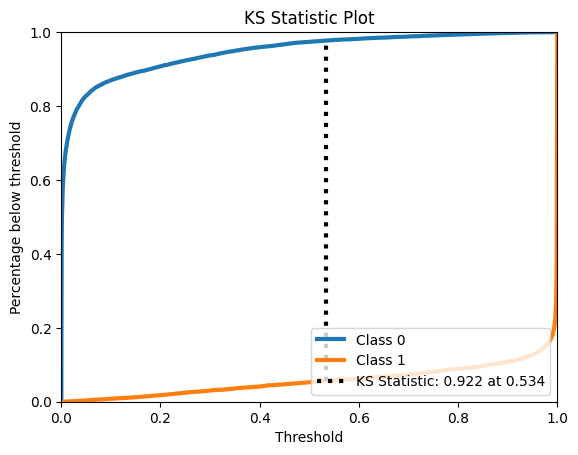

[I 2024-07-30 14:04:39,880] Trial 4 finished with values: [0.9948852532040721, 0.9217540738124654] and parameters: {'max_depth': 11, 'eta': 0.2, 'lambda': 4, 'alpha': 1, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.2
max_depth:11
lambda:4
alpha:1
grow_policy:depthwise

Accuracy:         0.9623
Recall:           0.9474
Precision:        0.9653
F1:               0.9562
AUROC:            0.9949
AUPR:             0.9940
[0]	validation-auc:0.98819
[1]	validation-auc:0.99009


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[2]	validation-auc:0.99064
[3]	validation-auc:0.99092
[4]	validation-auc:0.99156
[5]	validation-auc:0.99199
[6]	validation-auc:0.99233
[7]	validation-auc:0.99285
[8]	validation-auc:0.99306
[9]	validation-auc:0.99330
[10]	validation-auc:0.99339
[11]	validation-auc:0.99354
[12]	validation-auc:0.99364
[13]	validation-auc:0.99372
[14]	validation-auc:0.99379
[15]	validation-auc:0.99387
[16]	validation-auc:0.99394
[17]	validation-auc:0.99397
[18]	validation-auc:0.99399
[19]	validation-auc:0.99400
[20]	validation-auc:0.99403
[21]	validation-auc:0.99407
[22]	validation-auc:0.99408
[23]	validation-auc:0.99408
[24]	validation-auc:0.99410
[25]	validation-auc:0.99409
[26]	validation-auc:0.99410
[27]	validation-auc:0.99409
[28]	validation-auc:0.99410
[29]	validation-auc:0.99409
[30]	validation-auc:0.99409
[31]	validation-auc:0.99408
[32]	validation-auc:0.99409
[33]	validation-auc:0.99410


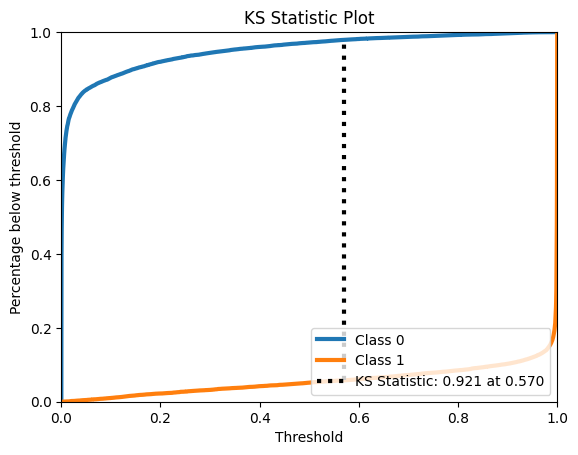

[I 2024-07-30 14:04:41,829] Trial 5 finished with values: [0.9948867896057455, 0.9214245619771908] and parameters: {'max_depth': 23, 'eta': 0.3, 'lambda': 3, 'alpha': 2, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.3
max_depth:23
lambda:3
alpha:2
grow_policy:depthwise

Accuracy:         0.9617
Recall:           0.9485
Precision:        0.9628
F1:               0.9556
AUROC:            0.9949
AUPR:             0.9940
[0]	validation-auc:0.98366
[1]	validation-auc:0.98534
[2]	validation-auc:0.98856
[3]	validation-auc:0.98917


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[4]	validation-auc:0.98946
[5]	validation-auc:0.99002
[6]	validation-auc:0.99039
[7]	validation-auc:0.99068
[8]	validation-auc:0.99105
[9]	validation-auc:0.99134
[10]	validation-auc:0.99164
[11]	validation-auc:0.99187
[12]	validation-auc:0.99232
[13]	validation-auc:0.99242
[14]	validation-auc:0.99260
[15]	validation-auc:0.99267
[16]	validation-auc:0.99283
[17]	validation-auc:0.99298
[18]	validation-auc:0.99308
[19]	validation-auc:0.99317
[20]	validation-auc:0.99321
[21]	validation-auc:0.99330
[22]	validation-auc:0.99337
[23]	validation-auc:0.99346
[24]	validation-auc:0.99351
[25]	validation-auc:0.99358
[26]	validation-auc:0.99364
[27]	validation-auc:0.99368
[28]	validation-auc:0.99371
[29]	validation-auc:0.99373
[30]	validation-auc:0.99375
[31]	validation-auc:0.99377
[32]	validation-auc:0.99380
[33]	validation-auc:0.99384
[34]	validation-auc:0.99389
[35]	validation-auc:0.99395
[36]	validation-auc:0.99397
[37]	validation-auc:0.99401
[38]	validation-auc:0.99404
[39]	validation-auc:0.9940

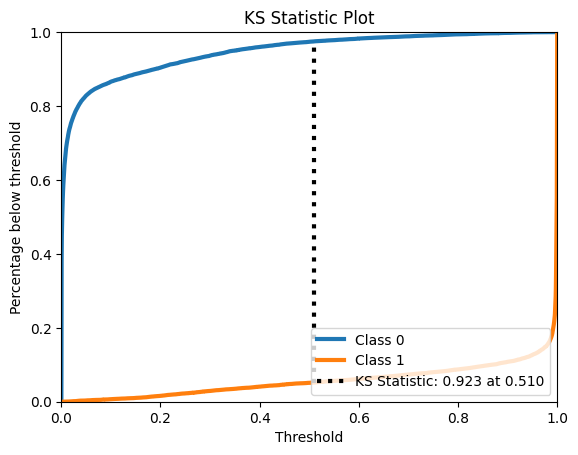

[I 2024-07-30 14:04:46,021] Trial 6 finished with values: [0.995083755914244, 0.9231858380392294] and parameters: {'max_depth': 37, 'eta': 0.15000000000000002, 'lambda': 4, 'alpha': 5, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.15000000000000002
max_depth:37
lambda:4
alpha:5
grow_policy:lossguide

Accuracy:         0.9629
Recall:           0.9488
Precision:        0.9652
F1:               0.9569
AUROC:            0.9951
AUPR:             0.9942
[0]	validation-auc:0.98766
[1]	validation-auc:0.98782
[2]	validation-auc:0.98806
[3]	validation-auc:0.98826


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[4]	validation-auc:0.98880
[5]	validation-auc:0.98898
[6]	validation-auc:0.98947
[7]	validation-auc:0.98949
[8]	validation-auc:0.98958
[9]	validation-auc:0.98974
[10]	validation-auc:0.98987
[11]	validation-auc:0.98998
[12]	validation-auc:0.99003
[13]	validation-auc:0.99012
[14]	validation-auc:0.99025
[15]	validation-auc:0.99023
[16]	validation-auc:0.99028
[17]	validation-auc:0.99030
[18]	validation-auc:0.99034
[19]	validation-auc:0.99046
[20]	validation-auc:0.99051
[21]	validation-auc:0.99080
[22]	validation-auc:0.99087
[23]	validation-auc:0.99094
[24]	validation-auc:0.99101
[25]	validation-auc:0.99106
[26]	validation-auc:0.99111
[27]	validation-auc:0.99120
[28]	validation-auc:0.99125
[29]	validation-auc:0.99131
[30]	validation-auc:0.99136
[31]	validation-auc:0.99136
[32]	validation-auc:0.99140
[33]	validation-auc:0.99145
[34]	validation-auc:0.99155
[35]	validation-auc:0.99179
[36]	validation-auc:0.99193
[37]	validation-auc:0.99202
[38]	validation-auc:0.99208
[39]	validation-auc:0.9921

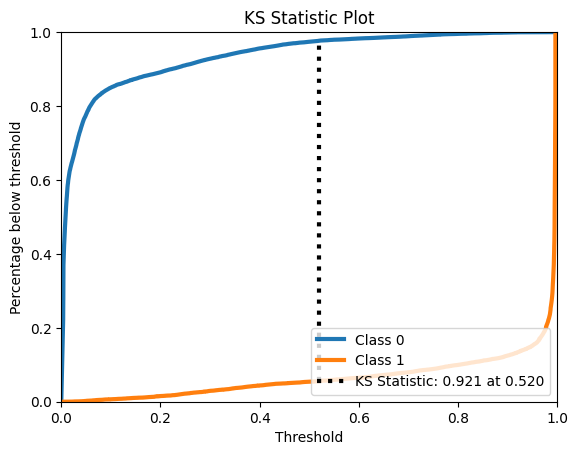

[I 2024-07-30 14:04:50,124] Trial 7 finished with values: [0.9943573235853511, 0.921029699026517] and parameters: {'max_depth': 12, 'eta': 0.05, 'lambda': 2, 'alpha': 2, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.05
max_depth:12
lambda:2
alpha:2
grow_policy:lossguide

Accuracy:         0.9617
Recall:           0.9457
Precision:        0.9653
F1:               0.9554
AUROC:            0.9944
AUPR:             0.9934
[0]	validation-auc:0.98853


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[1]	validation-auc:0.98990
[2]	validation-auc:0.99043
[3]	validation-auc:0.99100
[4]	validation-auc:0.99116
[5]	validation-auc:0.99179
[6]	validation-auc:0.99221
[7]	validation-auc:0.99238
[8]	validation-auc:0.99300
[9]	validation-auc:0.99316
[10]	validation-auc:0.99327
[11]	validation-auc:0.99344
[12]	validation-auc:0.99351
[13]	validation-auc:0.99357
[14]	validation-auc:0.99368
[15]	validation-auc:0.99373
[16]	validation-auc:0.99380
[17]	validation-auc:0.99388
[18]	validation-auc:0.99389
[19]	validation-auc:0.99394
[20]	validation-auc:0.99398
[21]	validation-auc:0.99400
[22]	validation-auc:0.99402
[23]	validation-auc:0.99408
[24]	validation-auc:0.99408
[25]	validation-auc:0.99412
[26]	validation-auc:0.99415
[27]	validation-auc:0.99416
[28]	validation-auc:0.99417
[29]	validation-auc:0.99417
[30]	validation-auc:0.99418
[31]	validation-auc:0.99419
[32]	validation-auc:0.99418
[33]	validation-auc:0.99417
[34]	validation-auc:0.99422
[35]	validation-auc:0.99422
[36]	validation-auc:0.99421
[

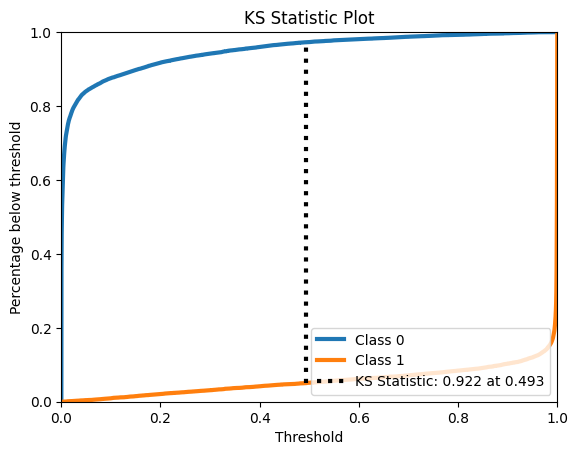

[I 2024-07-30 14:04:53,557] Trial 8 finished with values: [0.9949693017101876, 0.9222783380709128] and parameters: {'max_depth': 42, 'eta': 0.25, 'lambda': 1, 'alpha': 3, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.25
max_depth:42
lambda:1
alpha:3
grow_policy:lossguide

Accuracy:         0.9625
Recall:           0.9487
Precision:        0.9644
F1:               0.9565
AUROC:            0.9950
AUPR:             0.9941
[0]	validation-auc:0.98776
[1]	validation-auc:0.98915


/tmp/ipykernel_37579/2304358198.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[2]	validation-auc:0.98970
[3]	validation-auc:0.99016
[4]	validation-auc:0.99086
[5]	validation-auc:0.99121
[6]	validation-auc:0.99144
[7]	validation-auc:0.99193
[8]	validation-auc:0.99222
[9]	validation-auc:0.99263
[10]	validation-auc:0.99282
[11]	validation-auc:0.99300
[12]	validation-auc:0.99314
[13]	validation-auc:0.99329
[14]	validation-auc:0.99343
[15]	validation-auc:0.99348
[16]	validation-auc:0.99363
[17]	validation-auc:0.99369
[18]	validation-auc:0.99370
[19]	validation-auc:0.99374
[20]	validation-auc:0.99383
[21]	validation-auc:0.99388
[22]	validation-auc:0.99393
[23]	validation-auc:0.99399
[24]	validation-auc:0.99400
[25]	validation-auc:0.99404
[26]	validation-auc:0.99409
[27]	validation-auc:0.99410
[28]	validation-auc:0.99409
[29]	validation-auc:0.99410
[30]	validation-auc:0.99413
[31]	validation-auc:0.99413
[32]	validation-auc:0.99416
[33]	validation-auc:0.99415
[34]	validation-auc:0.99415
[35]	validation-auc:0.99416
[36]	validation-auc:0.99417
[37]	validation-auc:0.99418


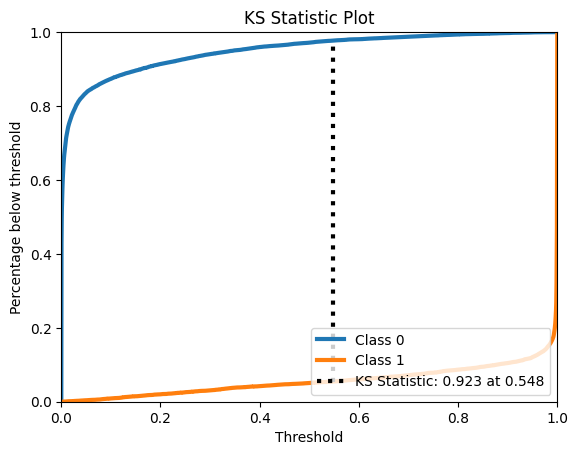

[I 2024-07-30 14:04:56,544] Trial 9 finished with values: [0.9948963515829943, 0.9227084610539604] and parameters: {'max_depth': 12, 'eta': 0.25, 'lambda': 1, 'alpha': 3, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.25
max_depth:12
lambda:1
alpha:3
grow_policy:lossguide

Accuracy:         0.9619
Recall:           0.9497
Precision:        0.9621
F1:               0.9559
AUROC:            0.9949
AUPR:             0.9940


In [20]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [21]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "optuna_results_xgb.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [22]:
df_existing

,number,values_0,values_1,params_alpha,params_eta,params_grow_policy,params_lambda,params_max_depth,user_attrs_accuracy,user_attrs_alpha,...,user_attrs_eta,user_attrs_f1,user_attrs_grow_policy,user_attrs_ks_statistic,user_attrs_lambda,user_attrs_max_depth,user_attrs_max_distance_at,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation
0,0,0.994244,0.918694,5,0.20,lossguide,2,5,0.960856,5,...,0.20,0.963795,lossguide,0.918694,2,5,0.470359,0.963795,0.945417,0
7,7,0.994357,0.921030,2,0.05,lossguide,2,12,0.961657,2,...,0.05,0.965340,lossguide,0.921030,2,12,0.520153,0.965340,0.945701,0
4,4,0.994885,0.921754,1,0.20,depthwise,4,11,0.962334,1,...,0.20,0.965261,depthwise,0.921754,4,11,0.534319,0.965261,0.947402,0
5,5,0.994887,0.921425,2,0.30,depthwise,3,23,0.961688,2,...,0.30,0.962798,depthwise,0.921425,3,23,0.569783,0.962798,0.948465,0
9,9,0.994896,0.922708,3,0.25,lossguide,1,12,0.961903,3,...,0.25,0.962085,lossguide,0.922708,1,12,0.548174,0.962085,0.949741,0
3,3,0.994945,0.921958,3,0.25,lossguide,5,16,0.962211,3,...,0.25,0.964512,lossguide,0.921958,5,16,0.517811,0.964512,0.947898,0
1,1,0.994963,0.923691,4,0.15,depthwise,4,24,0.963166,4,...,0.15,0.966000,depthwise,0.923691,4,24,0.514332,0.966000,0.948607,0
8,8,0.994969,0.922278,3,0.25,lossguide,1,42,0.962519,3,...,0.25,0.964404,lossguide,0.922278,1,42,0.493339,0.964404,0.948749,0
2,2,0.995049,0.923679,5,0.15,depthwise,5,41,0.962858,5,...,0.15,0.965572,depthwise,0.923679,5,41,0.527815,0.965572,0.948324,0
6,6,0.995084,0.923186,5,0.15,lossguide,4,37,0.962889,5,...,0.15,0.965172,lossguide,0.923186,4,37,0.510048,0.965172,0.948820,0


In [23]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9631659993840468
  Precision: 0.96600014437306
  Recall:    0.9486070745020203
  F1 Score:  0.96600014437306
  auroc:  0.9949632159382326
  ks_statistic:  0.9236914608813933
  max_distance_at:  0.5143316388130188
  Parameters: 
    max_depth:        24
    eta:              0.15000000000000002
    lambda:           4
    alpha:            4
    grow_policy:      depthwise

-- Overall Results (Ordered by auroc) --
   number  values_0  values_1  params_alpha  params_eta params_grow_policy  \
0       0  0.994244  0.918694             5        0.20          lossguide   
7       7  0.994357  0.921030             2        0.05          lossguide   
4       4  0.994885  0.921754             1        0.20          depthwise   
5       5  0.994887  0.921425             2        0.30          depthwise   
9       9  0.994896  0.922708             3        0.25          lossguide   
3       3  0.994945  0.921958             3        0.25          lossguide   
1   